<div style="border: none; margin: 5px 0; border-top: 1px dashed #FFFFFF; border-bottom: 1px dashed #FFFFFF; height: 5px;"></div>

<h2 style="color: #FFA07A;">6. Aplicação do modelo supervisionado</h2></h2>

In [1]:
#
import ipywidgets as widgets
import time

# --- Criar um aplicativo HTML para exibir o efeito de escrita ---
output = widgets.HTML(value="<div></div>")
display(output)

# --- Texto formatado para o efeito de escrita ---
texto = """
<div>
    <p><b>Análise explicativa de serviços urbanos:</b></p> 
    <p>🔸 Nesta secção, exploramos o potencial dos modelos de <b>aprendizagem automática supervisionada</b> para aprofundar a análise dos agrupamentos realizados pelo <b>K-means</b>. Através destas técnicas, é possível identificar padrões e <b>quantificar a importância relativa das variáveis</b> que influenciam os serviços urbanos. No presente estudo, estes modelos não foram utilizados para prever novos casos, mas sim para calcular um <b>índice de atratividade dos edifícios</b>, atribuindo pesos às variáveis de acordo com a sua relevância nos agrupamentos identificados.</p> 
    <p>🔸 Esta abordagem permite interpretar de forma clara as relações entre variáveis e orientar decisões para optimizar a distribuição e a qualidade dos serviços urbanos. Para garantir a robustez dos resultados e evitar o sobreajustamento, foi utilizada <b>validação cruzada k-fold (k=10)</b> durante o treino dos modelos.</p> 
    <p>🔸 <u><b>O primeiro passo consistiu em testar três modelos supervisionados sobre os dados, avaliando o respectivo desempenho e ajustando-os para obter a melhor estimativa do índice de atratividade.</b></u></p>
</div>
"""
texto_html = """
<div style="background-color: #FFFFFF; color: #333333; padding: 15px; 
            border-left: 5px solid #FFA500; font-family: Arial, sans-serif; 
            text-align: justify; font-size: 16px; line-height: 1.6;">
"""

# --- Efeito de escrita carácter a carácter (mantém o HTML) ---
for palavra in texto.split():
    texto_html += palavra + " "
    output.value = texto_html + "</div>"
    time.sleep(0.10)  # Ajustar velocidade
    
# --- Garantir que o texto completo é exibido no final ---
output.value = texto_html + "</div>"


HTML(value='<div></div>')

In [3]:
from IPython.display import Javascript, display
# hide-me
display(Javascript('window.cellVisibilityManager.hideCells();'))

# --- Importar bibliotecas ---
ipython = get_ipython()
ipython.run_line_magic("run", "1.preparacao_bibliotecas.ipynb")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# hide-me
display(Javascript('window.cellVisibilityManager.hideCells();'))

# --- Mensagem temporária inicial ---
print("[INFO] A calcular dados…")

# --- Carregar os dados ---
input_pkl_path = "df_servicos_clusters.pkl"
with open(input_pkl_path, 'rb') as pkl_file:
    data = pickle.load(pkl_file)
df_servicos = data['df']

# --- Transformações logarítmicas ---
df_servicos["distancia_media_servicos_log"] = np.log1p(df_servicos["distancia_media_servicos"])
df_servicos["pop_64_mais_log"] = np.log1p(df_servicos["pop_64_mais"])

# --- Coordenadas ---
if "coord_x" not in df_servicos.columns or "coord_y" not in df_servicos.columns:
    df_geo = gpd.GeoDataFrame(df_servicos, geometry='geometry', crs="EPSG:4326").to_crs(epsg=3763)
    df_servicos["coord_x"] = df_geo.geometry.centroid.x
    df_servicos["coord_y"] = df_geo.geometry.centroid.y

# --- Variáveis ---
variaveis = [
    "Centro Saude", "Farmacias", "Supermercados",
    "Parques e jardins", "Hospitais", "CTT",
    "distancia_media_servicos_log", "pop_64_mais_log", "coord_x", "coord_y"
]

X = df_servicos[variaveis].fillna(0)
y = df_servicos["numero_servicos_proximos"]

# --- Função de métricas ---
def calcular_metricas(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))
    medape = np.median(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1))) * 100
    cvrmse = rmse / np.mean(y_true) * 100
    return [r2, rmse, mae, rmsle, medape, cvrmse]

# --- Modelos ---
models = {
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42),
    "SVR": SVR(kernel='rbf'),
    "XGBoost": XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42)
}

# --- Validação cruzada k-fold ---
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics_results = {}

for nome, modelo in models.items():
    y_pred = cross_val_predict(modelo, X, y, cv=kf)
    metrics_results[nome] = calcular_metricas(y, y_pred)

# --- Resultados ---
results_df = pd.DataFrame(metrics_results).T.reset_index()
results_df.columns = ["Modelo", "R²", "RMSE", "MAE", "RMSLE", "MedAPE (%)", "CVRMSE (%)"]

# --- Mostrar ---
clear_output(wait=True)  # limpa a mensagem temporária
print("[INFO] Dados calculados. Ver tabela abaixo.\n")
print("\nResultados com validação cruzada k-fold (10):\n")
print(tabulate(results_df, headers=[f"{col:^15}" for col in results_df.columns],
               tablefmt='fancy_grid', showindex=False, colalign=["center"] * len(results_df.columns)))

#--- Mensagem final de informação ---
print("\033[92m[INFO] Após análise, pode continuar.\033[0m")

[INFO] Dados calculados. Ver tabela abaixo.


Resultados com validação cruzada k-fold (10):

╒═══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╕
│      Modelo       │        R²         │       RMSE        │        MAE        │       RMSLE       │    MedAPE (%)     │    CVRMSE (%)     │
╞═══════════════════╪═══════════════════╪═══════════════════╪═══════════════════╪═══════════════════╪═══════════════════╪═══════════════════╡
│   Random Forest   │     0.999853      │     0.228594      │     0.0522078     │     0.0146356     │         0         │     0.956807      │
├───────────────────┼───────────────────┼───────────────────┼───────────────────┼───────────────────┼───────────────────┼───────────────────┤
│        SVR        │    -0.0169302     │      19.041       │      13.8969      │     0.841595      │      57.4253      │      79.6982      │
├───────────────────┼───────────────────┼──────────────

In [4]:
#
import ipywidgets as widgets
import time

# --- Criar um aplicativo HTML para exibir o efeito de escrita ---
output = widgets.HTML(value="<div></div>")
display(output)

# --- Texto formatado para o efeito de escrita ---
texto = """
<div>
    <p style="font-size: 18px; font-weight: bold; color: #6A0DAD; text-align: justify;">Resumo Explicativo:</p> 
    <p>
        🔹 <b>Random Forest (Floresta Aleatória)</b> e <b>XGBoost</b> apresentaram os melhores resultados (R² ≈ 0,99; erros baixos).<br>
        🔹 O <b>XGBoost</b> (Extreme Gradient Boosting) foi selecionado como modelo nesta investigação devido à sua reconhecida eficiência, escalabilidade e robustez na modelação de relações complexas entre variáveis. <br>
        🔹 Utiliza <b>boosting</b> com Árvores de Decisão e regularização:
    </p>
    <ul>
        <li><b>L1 (Lasso):</b> elimina variáveis irrelevantes.</li>
        <li><b>L2 (Ridge):</b> estabiliza os coeficientes.</li>
    </ul>
    <p>
        🔹 Permite identificar os factores que mais influenciam as estimativas.<br>
        🔹 <b>Explicação das métricas:</b>
    </p>
    <ul>
        <li><b>R²:</b> qualidade do ajuste (ideal → 1).</li>
        <li><b>RMSE / MAE:</b> erro absoluto (quanto menor, melhor).</li>
        <li><b>RMSLE / MedAPE:</b> erro relativo, robusto face a valores extremos.</li>
        <li><b>Bias / CVRMSE:</b> enviesamento e consistência do modelo.</li>
    </ul>
    <p>🔹 O próximo passo será optimizar o <b>XGBoost</b> para modelar a <b>atractividade</b>.</p>
</div>
"""

# --- Efeito de escrita carácter a carácter (mantém o HTML) ---
texto_html = """
<div style="background-color: #FFFFFF; color: #333333; padding: 15px; 
            border-left: 5px solid #6A0DAD; font-family: Arial, sans-serif; 
            text-align: justify; font-size: 16px; line-height: 1.6;">
"""

for palavra in texto.split():
    texto_html += palavra + " "
    output.value = texto_html + "</div>"  
    time.sleep(0.10)# Ajustar velocidade
    
# --- Garantir que o texto completo é exibido no final ---
output.value = texto_html + "</div>"

HTML(value='<div></div>')

<div style="border: none; margin: 5px 0; border-top: 1px dashed #FFFFFF; border-bottom: 1px dashed #FFFFFF; height: 5px;"></div>

In [5]:
#
from IPython.display import display, HTML

#--- Conteúdo HTML para o título da secção com formatação ---
html_content = '<h2 style="color: #FFA07A;">6.1. Cálculo de pesos da variável "atratividade" com análise de componentes principais (PCA)</h2>'

#--- Apresentar o título HTML com formatação ---
display(HTML(html_content))

In [2]:
#
import ipywidgets as widgets
import time

#--- Criar um widget HTML para simular o efeito de escrita ---
output = widgets.HTML(value="<div></div>")
display(output)

#--- Texto formatado ---
texto = """
<div>
    <p><b>Análise de Componentes Principais (PCA):</b></p> 
    <p> 🔸 O PCA é uma técnica estatística de transformação linear utilizada para reduzir a dimensão de um conjunto de variáveis correlacionadas, projetando-as num novo espaço de variáveis não correlacionadas (os componentes principais), ordenadas pela quantidade de variância que cada uma explica.</p> 
    <p> 🔸 Neste estudo de caso, aplicou-se o PCA com <code>n_components=1</code> para obter um único vector de cargas (os coeficientes do primeiro componente). Estes coeficientes, após normalização, tornam-se os pesos utilizados na construção do índice de atractividade, uma vez que reflectem a importância relativa de cada variável na explicação da variância conjunta dos dados.</p>
</div>
"""

#--- Construir o contentor HTML com formatação para o efeito de escrita ---
texto_html = """
<div style="background-color: #FFFFFF; color: #333333; padding: 15px; 
            border-left: 5px solid #FFA500; font-family: Arial, sans-serif; 
            text-align: justify; font-size: 16px; line-height: 1.6;">
"""

# --- Efeito de escrita carácter a carácter (mantém o HTML) ---
for palavra in texto.split():
    texto_html += palavra + " "
    output.value = texto_html + "</div>"  
    time.sleep(0.10)   # Ajustar velocidade

# --- Garantir que o texto completo é exibido no final ---
output.value = texto_html + "</div>"

HTML(value='<div></div>')

<IPython.core.display.Javascript object>

Variância explicada pelo PC1: 0.554


,Variável,Carga (sinal),Peso relativo (|loading|/∑)
0,Supermercados,0.4357,0.1614
1,Bancos,0.4109,0.1522
2,Farmácias,0.4060,0.1504
3,CTT,0.4047,0.1499
4,Parques ou jardins,0.3571,0.1323
5,Centro de saúde,0.3487,0.1292
6,Hospitais,0.2365,0.0876
7,População com 65 anos ou +,-0.0869,0.0322
8,Proximidade (−distância),0.0132,0.0049


,corr_com_PC1
Supermercados,0.972709
Bancos,0.917258
Farmacias,0.906356
CTT,0.903407
Parques e jardins,0.797173
Centro Saude,0.778395
Hospitais,0.528063
prox_servicos,0.029426
pop_64_mais,-0.193974



Top correlações absolutas entre variáveis.


,Variável 1,Variável 2,corr_abs
2,Bancos,Supermercados,0.925418
23,Supermercados,CTT,0.883734
15,Farmacias,Supermercados,0.873545
5,Bancos,CTT,0.852827
1,Bancos,Farmacias,0.809991
18,Farmacias,CTT,0.785927
9,Centro Saude,Supermercados,0.770360
16,Farmacias,Parques e jardins,0.737577
21,Supermercados,Parques e jardins,0.723615
0,Bancos,Centro Saude,0.714278



Resumo da variância explicada (primeiras componentes):


,Componente,Variância explicada,Variância acumulada
0,PC1,0.5538,0.5538
1,PC2,0.1155,0.6692
2,PC3,0.1059,0.7751
3,PC4,0.0940,0.8691
4,PC5,0.0555,0.9246
5,PC6,0.0351,0.9597
6,PC7,0.0209,0.9806
7,PC8,0.0144,0.9950
8,PC9,0.0050,1.0000


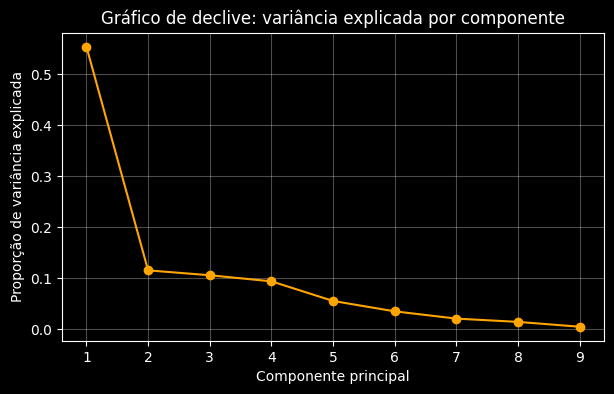

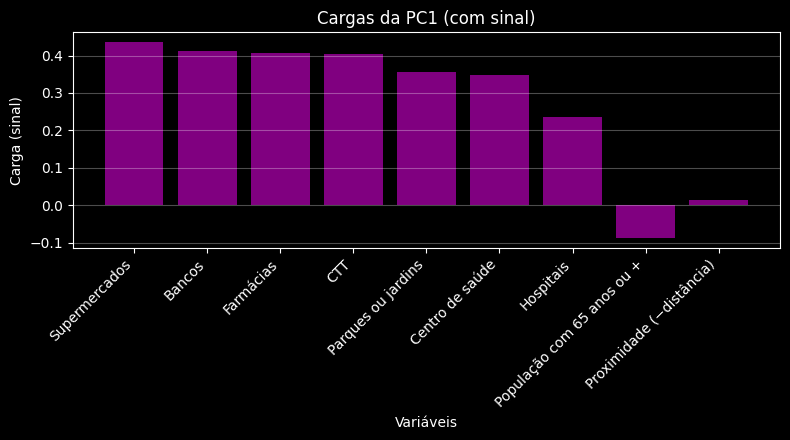

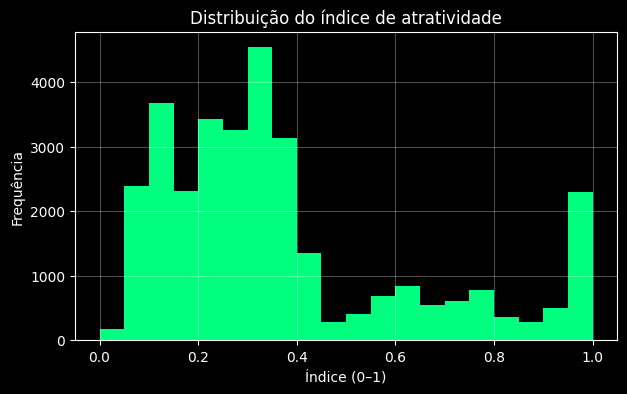

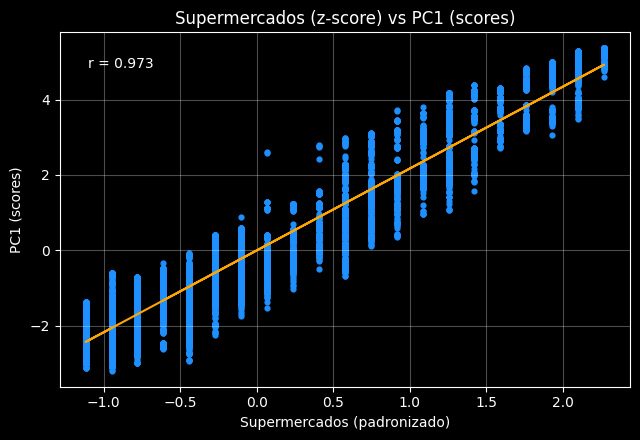

In [7]:
# hide-me
display(Javascript('window.cellVisibilityManager.hideCells();'))

# --- Importações ---
import base64, io
import matplotlib.pyplot as plt
from dash import Dash, dcc, html, dash_table, Input, Output
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# --- Estilo global do matplotlib (fundo preto) ---
plt.style.use("dark_background")

# ======================
# --- PROCESSAMENTO PCA ---
# ======================

def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    lo, hi = s.quantile(lower_q), s.quantile(upper_q)
    return s.clip(lo, hi)

vars_raw = [
    "Bancos", "Centro Saude", "Farmacias", "Supermercados",
    "Parques e jardins", "Hospitais", "CTT",
    "pop_64_mais", "distancia_media_servicos"
]
df_idx = df_servicos[vars_raw].copy()
df_idx = df_idx.fillna(0)

for col in df_idx.columns:
    df_idx[col] = winsorize_series(df_idx[col], 0.01, 0.99)

# --- Proximidade = sinal invertido da distância ---
df_idx["prox_servicos"] = -df_idx["distancia_media_servicos"]
df_idx = df_idx.drop(columns=["distancia_media_servicos"])

# --- Padronização (z-score) ---
scaler = StandardScaler()
Xz = scaler.fit_transform(df_idx.values)

# --- PCA (1 componente) orientada por 'Supermercados' ---
pca = PCA(n_components=1, random_state=42)
pc_scores = pca.fit_transform(Xz)
loadings = pca.components_[0]
col_ref = list(df_idx.columns).index("Supermercados")
if np.corrcoef(Xz[:, col_ref], pc_scores[:, 0])[0, 1] < 0:
    loadings *= -1
    pc_scores *= -1

# --- Índice de atratividade [0,1] ---
indice_continuo = pc_scores[:, 0]
indice_minmax = MinMaxScaler().fit_transform(indice_continuo.reshape(-1,1)).ravel()
df_servicos["atratividade"] = indice_minmax

labels = {
    'Bancos': 'Bancos',
    'Centro Saude': 'Centro de saúde',
    'Farmacias': 'Farmácias',
    'Supermercados': 'Supermercados',
    'Parques e jardins': 'Parques ou jardins',
    'Hospitais': 'Hospitais',
    'CTT': 'CTT',
    'pop_64_mais': 'População com 65 anos ou +',
    'prox_servicos': 'Proximidade (−distância)'
}

# --- Tabela de pesos ---
magnitudes = np.abs(loadings)
pesos_pos = magnitudes / magnitudes.sum()
df_pesos = pd.DataFrame({
    "Variável": [labels.get(c, c) for c in df_idx.columns],
    "Carga (sinal)": np.round(loadings, 4),
    "Peso relativo (|loading|/∑)": np.round(pesos_pos, 4)
}).sort_values("Peso relativo (|loading|/∑)", ascending=False).reset_index(drop=True)

# --- Correlações ---
corrs = pd.Series(
    np.corrcoef(Xz.T, pc_scores[:,0], rowvar=True)[-1, :-1],
    index=df_idx.columns, name="corr_com_PC1"
).sort_values(ascending=False)

# --- Top correlações absolutas entre variáveis ---
corr_mat = pd.DataFrame(Xz, columns=df_idx.columns).corr().abs()
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
pairs = upper.stack()
pairs_df = (pairs.rename("corr_abs")
                 .reset_index()
                 .sort_values("corr_abs", ascending=False)
                 .head(10))
pairs_df.columns = ["Variável 1", "Variável 2", "corr_abs"]
pairs_df["corr_abs"] = pairs_df["corr_abs"].round(6)

# --- PCA completo para scree plot ---
pca_full = PCA().fit(Xz)
var_ratio = pca_full.explained_variance_ratio_
var_cum = np.cumsum(var_ratio)
k_show = min(10, len(var_ratio))
df_var = pd.DataFrame({
    "Componente": [f"PC{i+1}" for i in range(k_show)],
    "Variância explicada": np.round(var_ratio[:k_show], 4),
    "Variância acumulada": np.round(var_cum[:k_show], 4)
})

# ======================
# --- GRÁFICOS -> BASE64 ---
# ======================
def figs_to_base64():
    figs = []

    # --- 1) Scree plot ---
    fig1, ax1 = plt.subplots(figsize=(7, 4))
    ax1.plot(range(1, k_show+1), var_ratio[:k_show], marker='o', color="#FFA500")
    ax1.set_title("Gráfico de declive: variância explicada por componente")
    ax1.set_xlabel("Componente principal")
    ax1.set_ylabel("Proporção de variância explicada")
    ax1.grid(True, alpha=0.3)
    buf1 = io.BytesIO(); plt.tight_layout(); fig1.savefig(buf1, format="png")
    figs.append(base64.b64encode(buf1.getvalue()).decode())

    # --- 2) Cargas da PC1 (corrige aviso de ticks) ---
    fig2, ax2 = plt.subplots(figsize=(8, 4.5))
    ord_idx = df_pesos["Peso relativo (|loading|/∑)"].values.argsort()[::-1]
    vars_ord = [df_pesos.loc[i, "Variável"] for i in ord_idx]
    loads_ord = [df_pesos.loc[i, "Carga (sinal)"] for i in ord_idx]
    ax2.bar(range(len(vars_ord)), loads_ord, color="#800080")
    ax2.set_xticks(range(len(vars_ord)))                       # define os ticks
    ax2.set_xticklabels(vars_ord, rotation=45, ha="right")     # agora é seguro definir labels
    ax2.set_title("Cargas da PC1 (com sinal)")
    ax2.set_xlabel("Variáveis")
    ax2.set_ylabel("Carga (sinal)")
    ax2.grid(True, axis='y', alpha=0.3)
    buf2 = io.BytesIO(); plt.tight_layout(); fig2.savefig(buf2, format="png")
    figs.append(base64.b64encode(buf2.getvalue()).decode())

    # --- 3) Histograma do índice ---
    fig3, ax3 = plt.subplots(figsize=(7, 4))
    ax3.hist(indice_minmax, bins=20, color="#00FF7F")
    ax3.set_title("Distribuição do índice de atratividade")
    ax3.set_xlabel("Índice (0–1)")
    ax3.set_ylabel("Frequência")
    ax3.grid(True, alpha=0.3)
    buf3 = io.BytesIO(); plt.tight_layout(); fig3.savefig(buf3, format="png")
    figs.append(base64.b64encode(buf3.getvalue()).decode())

    # --- 4) Dispersão Supermercados vs PC1 ---
    fig4, ax4 = plt.subplots(figsize=(6.5, 4.5))
    col_sup = list(df_idx.columns).index("Supermercados")
    ax4.scatter(Xz[:, col_sup], pc_scores[:, 0], s=12, color="#1E90FF")
    m, b = np.polyfit(Xz[:, col_sup], pc_scores[:, 0], 1)
    ax4.plot(Xz[:, col_sup], m*Xz[:, col_sup] + b, color="#FFA500")
    ax4.set_title("Supermercados (z-score) vs PC1 (scores)")
    ax4.set_xlabel("Supermercados (padronizado)")
    ax4.set_ylabel("PC1 (scores)")
    ax4.grid(True, alpha=0.3)
    r_sup = np.corrcoef(Xz[:, col_sup], pc_scores[:, 0])[0, 1]
    ax4.annotate(f"r = {r_sup:.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
    buf4 = io.BytesIO(); plt.tight_layout(); fig4.savefig(buf4, format="png")
    figs.append(base64.b64encode(buf4.getvalue()).decode())

    plt.close('all')
    return figs

figs_base64 = figs_to_base64()

# ======================
# --- DASH APP (sem “faixa” e com contornos corretos) ---
# ======================

app = Dash(__name__, suppress_callback_exceptions=True)

page_style = {'backgroundColor': '#000', 'minHeight': '100vh', 'padding': '24px'}

# --- Container principal: sem padding; sem linha entre borda e título ---
main_container_style = {
    'backgroundColor': '#000',
    'border': '3px solid white',
    'borderRadius': '6px',
    'padding': '0px',          
    'maxWidth': '1200px',
    'margin': '0 auto'
}

# --- Wrapper do título sem borda (apenas para dar respiro) ---
title_wrapper_style = {'margin': '14px'}

# --- Título com contorno fino ---
title_style = {
    'textAlign': 'center',
    'color': 'white',
    'backgroundColor': '#000',
    'border': '1px solid white',
    'padding': '12px',
    'fontWeight': 'bold',
    'fontSize': '28px',
    'margin': '0'               
}

# --- Abas com contorno fino ---
tab_style = {'backgroundColor': '#000', 'color': 'white', 'padding': '10px', 'border': '1px solid white'}
tab_selected_style = {'backgroundColor': '#000', 'color': 'white', 'padding': '10px',
                      'border': '1px solid white', 'borderTop': '4px solid #ffcc00'}

datatable_common = dict(
    style_table={'overflowX': 'auto', 'border': '1px solid white'},
    style_header={'backgroundColor': '#000', 'color': 'white', 'border': '1px solid white'},
    style_cell={'backgroundColor': '#111', 'color': 'white', 'border': '1px solid #333'}
)

app.layout = html.Div([
    html.Div([
        # --- Título (sem linha entre bordas) ---
        html.Div([ html.H1("Análise PCA e Índice de Atratividade", style=title_style) ],
                 style=title_wrapper_style),

        # --- Abas (sem linha extra) ---
        dcc.Tabs(
            id="tabs", value='tab-graficos',
            children=[
                dcc.Tab(label='Tabelas', value='tab-tabelas',
                        style=tab_style, selected_style=tab_selected_style),
                dcc.Tab(label='Gráficos', value='tab-graficos',
                        style=tab_style, selected_style=tab_selected_style),
            ],
            style={'backgroundColor': '#000', 'margin': '0 14px'}
        ),

        html.Div(id='tabs-content', style={'margin': '14px'})
    ], style=main_container_style)
], style=page_style)

# --- Conteúdo das abas ---
@app.callback(Output('tabs-content', 'children'), Input('tabs', 'value'))
def render_tab_content(tab):
    if tab == 'tab-tabelas':
        return html.Div([
            html.H3("Pesos (PC1)", style={'color': 'white'}),
            dash_table.DataTable(
                data=df_pesos.to_dict('records'),
                columns=[{"name": i, "id": i} for i in df_pesos.columns],
                **datatable_common
            ),
            html.H3("Correlação com PC1", style={'color': 'white', 'marginTop': '20px'}),
            dash_table.DataTable(
                data=corrs.to_frame().reset_index().to_dict('records'),
                columns=[{"name": "Variável", "id": "index"},
                         {"name": "corr_com_PC1", "id": "corr_com_PC1"}],
                **datatable_common
            ),
            html.H3("Top correlações absolutas", style={'color': 'white', 'marginTop': '20px'}),
            dash_table.DataTable(
                data=pairs_df.to_dict('records'),
                columns=[{"name": i, "id": i} for i in pairs_df.columns],
                **datatable_common
            ),
            html.H3("Resumo da variância explicada", style={'color': 'white', 'marginTop': '20px'}),
            dash_table.DataTable(
                data=df_var.to_dict('records'),
                columns=[{"name": i, "id": i} for i in df_var.columns],
                **datatable_common
            )
        ])

    # --- Gráficos centrados ---
    img_style = {'display': 'block', 'margin': '18px auto', 'maxWidth': '100%'}
    if tab == 'tab-graficos':
        return html.Div([
            html.H3("Gráficos PCA", style={'color': 'white', 'textAlign': 'center'}),
            html.Img(src=f"data:image/png;base64,{figs_base64[0]}", style=img_style),
            html.Img(src=f"data:image/png;base64,{figs_base64[1]}", style=img_style),
            html.Img(src=f"data:image/png;base64,{figs_base64[2]}", style=img_style),
            html.Img(src=f"data:image/png;base64,{figs_base64[3]}", style=img_style)
        ], style={'border': '1px solid white', 'borderRadius': '4px', 'padding': '8px'})

# --- Encontrar uma porta de rede livre para o painel interativo ---
def encontrar_porta_livre():
    while True:
        porta = random.randint(8000, 9000)
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            if s.connect_ex(("localhost", porta)) != 0:
                return porta

porta = encontrar_porta_livre()

# --- Lançar aplicação interativa quando o ficheiro for executado diretamente ---
if __name__ == '__main__':
    app.run(debug=False, port=porta)

# ---- Mensagem final---
print("\033[92m[INFO] Após análise, pode continuar.\033[0m")

<div style="border: none; margin: 5px 0; border-top: 1px dashed #FFFFFF; border-bottom: 1px dashed #FFFFFF; height: 5px;"></div>

In [8]:
#-
from IPython.display import display, HTML

#--- Conteúdo HTML para o título da secção, com estilo de cor personalizado ---
html_content = '<h2 style="color: #FFA07A;">6.2. Cálculo de pesos da variável "atratividade" com análise fatorial confirmatória (CFA)</h2>'

#--- Apresentar o título HTML com formatação personalizada ---
display(HTML(html_content))

In [6]:
#
import ipywidgets as widgets
import time

# --- Criar um aplicativo HTML para exibir o efeito de escrita ---
output = widgets.HTML(value="<div></div>")
display(output)

# --- Texto formatado para o efeito de escrita ---
texto = """
<div>
    <p><b>Análise Fatorial Confirmatória (CFA):</b></p> 
    <p>🔸 A CFA ajusta um modelo de equações estruturais no qual uma variável latente (“Atratividade”) é medida por nove indicadores de serviços, os mesmos utilizados na análise PCA: bancos, supermercados, farmácias, CTT, parques ou jardins, centros de saúde, hospitais, proximidade aos serviços (−distância) e população com 65 anos ou mais.</p>
    <p>🔸 Antes da análise, todas as variáveis foram padronizadas (z-score) para garantir comparabilidade, e a proximidade foi calculada como o inverso da distância média aos serviços, de modo a que valores mais altos correspondam a maior proximidade.</p>
    <p>🔸 O modelo foi estimado testando diferentes métodos:
        <ul>
            <li><b>DWLS</b> (Diagonally Weighted Least Squares) – ajusta melhor dados que não seguem a distribuição normal e lida bem com variáveis ordinais;</li>
            <li><b>MLW</b> (Maximum Likelihood Weighted) – semelhante ao método de máxima verosimilhança, mas ponderado para dados com características específicas;</li>
            <li><b>ML</b> (Maximum Likelihood) – método de máxima verosimilhança, assume que os dados seguem uma distribuição normal.</li>
        </ul>
        O algoritmo escolheu automaticamente o método mais adequado para os dados.
    </p>
    <p><b>Para que serve:</b></p>
    <p>🔸 As cargas fatoriais padronizadas mostram a relevância de cada indicador na definição do fator “Atratividade”. Por exemplo, se “Farmácias” tiver uma carga padronizada de 0,80, significa que é um bom indicador do fator. Neste estudo, as cargas foram calculadas manualmente como correlações entre cada variável padronizada e o escore estimado do fator.</p>
    <p>🔸 Foram ainda calculados índices de ajustamento para avaliar a qualidade global do modelo:
        <ul>
            <li><b>CFI</b> (Comparative Fit Index) – indica o quão bem o modelo se ajusta aos dados, comparando-o com um modelo de referência (valores próximos de 1 indicam ótimo ajustamento);</li>
            <li><b>TLI</b> (Tucker-Lewis Index) – semelhante ao CFI, mas penaliza modelos excessivamente complexos (ideal próximo de 1);</li>
            <li><b>RMSEA</b> (Root Mean Square Error of Approximation) – mede o erro médio de aproximação; valores abaixo de 0,05 indicam bom ajustamento;</li>
            <li><b>SRMR</b> (Standardized Root Mean Square Residual) – mede a diferença média entre as correlações previstas e observadas; valores abaixo de 0,08 indicam bom ajustamento.</li>
        </ul>
    </p>
</div>
"""

texto_html = """
<div style="background-color: #FFFFFF; color: #333333; padding: 15px; 
            border-left: 5px solid #FFA500; font-family: Arial, sans-serif; 
            text-align: justify; font-size: 16px; line-height: 1.6;">
"""

# --- Efeito de escrita carácter a carácter (mantém o HTML) ---
for palavra in texto.split():
    texto_html += palavra + " "
    output.value = texto_html + "</div>"  
    time.sleep(0.10)  # Ajustar velocidade

# --- Garantir que o texto completo é exibido no final ---
output.value = texto_html + "</div>"

HTML(value='<div></div>')

In [7]:
# hide-me
display(Javascript('window.cellVisibilityManager.hideCells();'))

# --- Criar o conjunto de dados (dataset) a partir do df_idx já existente ---
df_cfa = pd.DataFrame({
    "Bancos":               df_idx["Bancos"].values,
    "Supermercados":        df_idx["Supermercados"].values,
    "Farmacias":            df_idx["Farmacias"].values,
    "CTT":                  df_idx["CTT"].values,
    "Parques_ou_jardins":   df_idx["Parques e jardins"].values,
    "Centro_de_saude":      df_idx["Centro Saude"].values,
    "Hospitais":            df_idx["Hospitais"].values,
    "Proximidade":          df_idx["prox_servicos"].values,  # já é -distância
    "Populacao_65":         df_idx["pop_64_mais"].values
})

# 1) Padronizar variáveis (z-score)
scaler = StandardScaler()
df_cfa_z = pd.DataFrame(
    scaler.fit_transform(df_cfa),
    columns=df_cfa.columns, index=df_cfa.index
)

# --- Definir o modelo (numa única linha) ---
modelo_1f = """
Atratividade =~ Bancos + Supermercados + Farmacias + CTT + Parques_ou_jardins + Centro_de_saude + Hospitais + Proximidade + Populacao_65
"""

# --- Ajustar o modelo, com recurso a métodos alternativos se o objetivo principal falhar ---
mod = Model(modelo_1f)
objetivo_usado, last_err = None, None
for obj in ("DWLS", "MLW", "ML"):
    try:
        mod.fit(df_cfa_z, obj=obj)
        objetivo_usado = obj
        break
    except Exception as e:
        last_err = e
if objetivo_usado is None:
    raise RuntimeError(f"Falha ao ajustar o modelo. Último erro: {last_err}")

print(f"Objetivo usado: {objetivo_usado}")

# --- Calcular índices de ajustamento (compatível com vários formatos de retorno) ---
stats_raw = calc_stats(mod)
if isinstance(stats_raw, pd.DataFrame):
    fit_series = stats_raw.iloc[0]
elif isinstance(stats_raw, pd.Series):
    fit_series = stats_raw
elif isinstance(stats_raw, dict):
    fit_series = pd.Series(stats_raw)
else:
    fit_series = pd.Series(dtype=float)
fit_series.index = [str(k).upper() for k in fit_series.index]
order = ["DOF","CHI2","P-VALUE","RMSEA","CFI","TLI","SRMR","GFI","AGFI","NFI","AIC","BIC","LOGLIK","DOF BASELINE","CHI2 BASELINE"]
ordered = [k for k in order if k in fit_series.index]
fit_out = fit_series[ordered + [k for k in fit_series.index if k not in ordered]]

print("\n=== Índices de ajuste ===")
display(fit_out)

# --- Calcular cargas padronizadas de forma manual (correlação entre cada indicador e o fator previsto) --
factors = mod.predict_factors(df_cfa_z)      # DataFrame com os valores fatoriais
nome_fator = factors.columns[0]              # "Atratividade"
scores = factors[nome_fator].to_numpy()

cargas_calc = []
for col in df_cfa_z.columns:
    r = np.corrcoef(df_cfa_z[col].to_numpy(), scores)[0, 1]
    cargas_calc.append((nome_fator, col, r))

loads_manual = (pd.DataFrame(cargas_calc, columns=["Fator","Indicador","Carga padronizada"])
                  .assign(**{"|Carga|": lambda d: d["Carga padronizada"].abs()})
                  .sort_values("|Carga|", ascending=False)
                  .drop(columns="|Carga|")
                  .reset_index(drop=True))

#--- Mensagem final ---
print("\n=== Cargas padronizadas calculadas ===")
display(loads_manual.round(6))

<IPython.core.display.Javascript object>

Objetivo usado: DWLS

=== Índices de ajuste ===


DOF                  27.000000
CHI2               1656.179341
RMSEA                 0.043511
CFI                   0.992188
TLI                   0.989584
GFI                   0.992060
AGFI                  0.989413
NFI                   0.992060
AIC                  34.993348
BIC                 185.644610
LOGLIK                0.503326
DOF BASELINE         36.000000
CHI2 BASELINE    208588.078856
CHI2 P-VALUE          0.000000
Name: Value, dtype: float64


=== Cargas padronizadas (calculadas manualmente) ===


,Fator,Indicador,Carga padronizada
0,Atratividade,Supermercados,1.000000
1,Atratividade,Bancos,0.925418
2,Atratividade,CTT,0.883734
3,Atratividade,Farmacias,0.873545
4,Atratividade,Centro_de_saude,0.770360
5,Atratividade,Parques_ou_jardins,0.723615
6,Atratividade,Hospitais,0.437683
7,Atratividade,Populacao_65,-0.141703
8,Atratividade,Proximidade,0.037049


In [10]:
#
import ipywidgets as widgets
import time

# --- Criar um aplicativo HTML para exibir o efeito de escrita ---
output = widgets.HTML(value="<div></div>")
display(output)

# --- Texto formatado para o efeito de escrita -
texto = """
<div>
    <p style="font-size: 18px; font-weight: bold; color: #6A0DAD; text-align: justify;">Resumo dos resultados:</p> 
    <p>🔹 Os pesos obtidos pela PCA e as cargas fatoriais da CFA estão alinhados, o que confirma a coerência da estrutura latente do fator “Atratividade”.</p>
    <p>🔹 Variáveis como <b>supermercados</b>, <b>bancos</b>, <b>CTT</b> e <b>farmácias</b> apresentam cargas fatoriais elevadas (&gt; 0,85), sendo os melhores indicadores do fator.</p>
    <p>🔹 <b>Centros de saúde</b> e <b>parques ou jardins</b> registam cargas intermédias, contribuindo de forma moderada para a atratividade.</p>
    <p>🔹 <b>Hospitais</b> apresentam carga mais baixa, enquanto a <b>população com 65 anos ou mais</b> tem carga negativa, sugerindo uma relação inversa com a atratividade.</p>
    <p>🔹 A <b>proximidade</b> (−distância média aos serviços) apresenta carga muito baixa, revelando fraca associação direta com o fator.</p>
</div>
"""


texto_html = """
<div style="background-color: #FFFFFF; color: #333333; padding: 15px; 
            border-left: 5px solid #6A0DAD; font-family: Arial, sans-serif; 
            text-align: justify; font-size: 16px; line-height: 1.6;">
"""

# --- Efeito de escrita carácter a carácter (mantém o HTML) ---
for palavra in texto.split():
    texto_html += palavra + " "
    output.value = texto_html + "</div>"
    time.sleep(0.10) # Ajustar velocidade

# --- Garantir que o texto completo é exibido no final ---
output.value = texto_html + "</div>"

HTML(value='<div></div>')

<div style="border: none; margin: 5px 0; border-top: 1px dashed #FFFFFF; border-bottom: 1px dashed #FFFFFF; height: 5px;"></div>

Seguinte: [Aplicação do XGBoost](7.atratividade_XGBoost_base.ipynb)

<div style="border: none; margin: 5px 0; border-top: 1px dashed #FFFFFF; border-bottom: 1px dashed #FFFFFF; height: 5px;"></div>